<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [AE1] - Building and training an AE denoiser model
<!-- DESC --> Episode 1 : After construction, the model is trained with noisy data from the MNIST dataset.

<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understanding and implementing a denoizing **autoencoder** neurals network (AE)
 - Understanding a more **advanced programming model**

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST.  
The use of a GPU is often indispensable.

## What we're going to do :

 - Defining a VAE model
 - Build the model
 - Train it
 - Follow the learning process with Tensorboard

Thanks to **François Chollet** whose VAE example has greatly inspired this example.  
See : https://keras.io/examples/generative/vae


## Step 1 - Init python stuff

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from modules.callbacks          import ImagesCallback
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import os,sys,json,time,datetime
from importlib import reload
from IPython.display import display,Image,Markdown,HTML
import h5py

from skimage import io
from skimage.util import random_noise

import modules.AE
from modules.AE           import AE
from modules.loader_MNIST import Loader_MNIST
from modules.callbacks    import ImagesCallback, BestModelCallback

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('AE1')

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.14
Notebook id          : AE1
Run time             : Wednesday 10 February 2021, 10:57:55
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


## Step 2 - Prepare data
### 2.1 - Get MNIST dataset

In [2]:
x_data, y_data = Loader_MNIST.get()

Dataset loaded.
Normalized.
Expanded.
Concatenate.
x shape : (70000, 28, 28, 1)
y shape : (70000,)


### 2.2 - Add noise to dataset
We will add noise to our input dataset (x_data)  
Our goal is to predict noiselessly data (y_data)

In [3]:
def noise_it(x_data, about):
    for i,image in enumerate(x_data):
        pwk.update_progress(about,i+1,len(x_data))
        image=random_noise(image, mode='gaussian', mean=0, var=0.3)
        image=random_noise(image, mode='s&p',      amount=0.2, salt_vs_pepper=0.5)
        image=random_noise(image, mode='poisson') 
        image=random_noise(image, mode='speckle',  mean=0, var=0.1)
        x_data[i]=image
    return x_data


# ---- What we want to predict
#
y_data = np.copy(x_data)

# ---- Add noise to input data
#
x_data = noise_it(x_data, 'Add noise to x_train :')


Add noise to x_train : [########################################] 100.0% of 70000


### 2.3 - Have a look

Noisy dataset (x_data) :  (70000, 28, 28, 1)
Clean dataset (y_data) :  (70000, 28, 28, 1)


<br>**Noisy images (input data)**

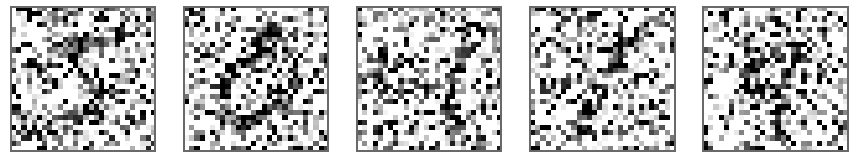

<br>**Original images we want to obtain (output data)**

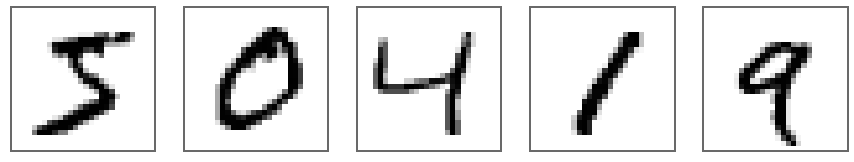

In [4]:
print('Noisy dataset (x_data) : ',x_data.shape)
print('Clean dataset (y_data) : ',y_data.shape)

pwk.subtitle('Noisy images (input data)')
pwk.plot_images(x_data[:5], None, indices='all', columns=5, x_size=3,y_size=3, interpolation=None, save_as='01-noisy')
pwk.subtitle('Original images we want to obtain (output data)')
pwk.plot_images(y_data[:5], None, indices='all', columns=5, x_size=3,y_size=3, interpolation=None, save_as='02-original')


### 2.4 - Shuffle and split dataset

In [5]:
p = np.random.permutation(len(x_data))
x_data, y_data = x_data[p], y_data[p]
x_train, y_train = x_data[:60000], y_data[:60000]
x_test,  y_test  = x_data[60000:], y_data[60000:]

print(f'x_train:{x_train.shape}  y_train:{y_train.shape}')
print(f'x_test :{x_test.shape}  y_test :{y_test.shape}')

x_train:(60000, 28, 28, 1)  y_train:(60000, 28, 28, 1)
x_test :(10000, 28, 28, 1)  y_test :(10000, 28, 28, 1)


### 2.5 - Save it

In [6]:
pwk.mkdir('./data')

with h5py.File('./data/mnist-noisy.h5', "w") as f:
    f.create_dataset("x_train", data=x_train)
    f.create_dataset("y_train", data=y_train)
    f.create_dataset("x_test",  data=x_test)
    f.create_dataset("y_test",  data=y_test)
    print('Saved.')

Saved.


## Step 3 - Build model

In [7]:
latent_dim = 10

#### Encoder

In [8]:
reload(modules.AE)
from modules.AE          import AE

inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x         = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)
z         = layers.Dense(latent_dim)(x)

encoder = keras.Model(inputs, z, name="encoder")
encoder.compile()
# encoder.summary()

#### Decoder

In [9]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x       = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.compile()
# decoder.summary()

#### AE


In [10]:
ae = AE(encoder, decoder)

ae.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy')

## Step 4 - Train
20' on a CPU  
1'12 on a GPU (V100, IDRIS)

In [11]:
# ---- Callback : Images
pwk.mkdir('./run/images')
filename = './run/images/image-{epoch:03d}-{i:02d}.jpg'
callback_images = ImagesCallback(filename, x=x_test[:5], encoder=encoder,decoder=decoder)

# ---- Callback : Best model
pwk.mkdir('./run/models')
filename = './run/models/best_model'
callback_bestmodel = BestModelCallback(filename)

# ---- Callback tensorboard
dirname = './run/logs'
callback_tensorboard = TensorBoard(log_dir=dirname, histogram_freq=1)

callbacks_list = [callback_images, callback_bestmodel, callback_tensorboard]

In [12]:
%%time

n          = 60000
batch_size = 128
epochs     = 30

history = ae.fit(x_train[:n],y_train[:n], epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/30


  1/469 [..............................] - ETA: 27:30 - loss: 0.6930

  3/469 [..............................] - ETA: 43s - loss: 0.6915  

 16/469 [>.............................] - ETA: 7s - loss: 0.6369 

 29/469 [>.............................] - ETA: 4s - loss: 0.5674

 42/469 [=>............................] - ETA: 3s - loss: 0.5181

 56/469 [==>...........................] - ETA: 2s - loss: 0.4812

 70/469 [===>..........................] - ETA: 2s - loss: 0.4545

 84/469 [====>.........................] - ETA: 2s - loss: 0.4342

 98/469 [=====>........................] - ETA: 2s - loss: 0.4183

112/469 [======>.......................] - ETA: 1s - loss: 0.4054

126/469 [=======>......................] - ETA: 1s - loss: 0.3947

140/469 [=======>......................] - ETA: 1s - loss: 0.3857

154/469 [========>.....................] - ETA: 1s - loss: 0.3779

168/469 [=========>....................] - ETA: 1s - loss: 0.3712

182/469 [==========>...................] - ETA: 1s - loss: 0.3653

196/469 [===========>..................] - ETA: 1s - loss: 0.3600

210/469 [============>.................] - ETA: 1s - loss: 0.3553

224/469 [=============>................] - ETA: 1s - loss: 0.3510

238/469 [==============>...............] - ETA: 1s - loss: 0.3471

252/469 [===============>..............] - ETA: 0s - loss: 0.3435

253/469 [===============>..............] - ETA: 1s - loss: 0.3432

267/469 [================>.............] - ETA: 0s - loss: 0.3400

281/469 [================>.............] - ETA: 0s - loss: 0.3369

295/469 [=================>............] - ETA: 0s - loss: 0.3341

309/469 [==================>...........] - ETA: 0s - loss: 0.3315

323/469 [===================>..........] - ETA: 0s - loss: 0.3290

337/469 [====================>.........] - ETA: 0s - loss: 0.3267

351/469 [=====================>........] - ETA: 0s - loss: 0.3245

365/469 [======================>.......] - ETA: 0s - loss: 0.3224

379/469 [=======================>......] - ETA: 0s - loss: 0.3204

393/469 [========================>.....] - ETA: 0s - loss: 0.3185

407/469 [=========================>....] - ETA: 0s - loss: 0.3167

422/469 [=========================>....] - ETA: 0s - loss: 0.3148

436/469 [==========================>...] - ETA: 0s - loss: 0.3131

450/469 [===========================>..] - ETA: 0s - loss: 0.3115

464/469 [============================>.] - ETA: 0s - loss: 0.3099

469/469 [==============================] - ETA: 0s - loss: 0.3093

469/469 [==============================] - 6s 4ms/step - loss: 0.3092


           (saved) Epoch 2/30
  1/469 [..............................] - ETA: 1s - loss: 0.2134

 15/469 [..............................] - ETA: 1s - loss: 0.2096

 29/469 [>.............................] - ETA: 1s - loss: 0.2086

 43/469 [=>............................] - ETA: 1s - loss: 0.2079

 57/469 [==>...........................] - ETA: 1s - loss: 0.2073

 71/469 [===>..........................] - ETA: 1s - loss: 0.2068

 85/469 [====>.........................] - ETA: 1s - loss: 0.2062

 99/469 [=====>........................] - ETA: 1s - loss: 0.2057

113/469 [======>.......................] - ETA: 1s - loss: 0.2051

127/469 [=======>......................] - ETA: 1s - loss: 0.2046

141/469 [========>.....................] - ETA: 1s - loss: 0.2042

155/469 [========>.....................] - ETA: 1s - loss: 0.2037

169/469 [=========>....................] - ETA: 1s - loss: 0.2033

183/469 [==========>...................] - ETA: 1s - loss: 0.2029

197/469 [===========>..................] - ETA: 0s - loss: 0.2025

211/469 [============>.................] - ETA: 0s - loss: 0.2022

225/469 [=============>................] - ETA: 0s - loss: 0.2019

239/469 [==============>...............] - ETA: 0s - loss: 0.2015

253/469 [===============>..............] - ETA: 0s - loss: 0.2012

267/469 [================>.............] - ETA: 0s - loss: 0.2009

281/469 [================>.............] - ETA: 0s - loss: 0.2006

295/469 [=================>............] - ETA: 0s - loss: 0.2003

309/469 [==================>...........] - ETA: 0s - loss: 0.2000

323/469 [===================>..........] - ETA: 0s - loss: 0.1997

337/469 [====================>.........] - ETA: 0s - loss: 0.1995

351/469 [=====================>........] - ETA: 0s - loss: 0.1992

365/469 [======================>.......] - ETA: 0s - loss: 0.1989

379/469 [=======================>......] - ETA: 0s - loss: 0.1987

393/469 [========================>.....] - ETA: 0s - loss: 0.1984

407/469 [=========================>....] - ETA: 0s - loss: 0.1982

421/469 [=========================>....] - ETA: 0s - loss: 0.1979

435/469 [==========================>...] - ETA: 0s - loss: 0.1977

449/469 [===========================>..] - ETA: 0s - loss: 0.1975

463/469 [============================>.] - ETA: 0s - loss: 0.1972

469/469 [==============================] - 2s 4ms/step - loss: 0.1971


           (saved) Epoch 3/30
  1/469 [..............................] - ETA: 1s - loss: 0.1785

 15/469 [..............................] - ETA: 1s - loss: 0.1781

 29/469 [>.............................] - ETA: 1s - loss: 0.1777

 43/469 [=>............................] - ETA: 1s - loss: 0.1773

 57/469 [==>...........................] - ETA: 1s - loss: 0.1772

 71/469 [===>..........................] - ETA: 1s - loss: 0.1770

 85/469 [====>.........................] - ETA: 1s - loss: 0.1769

 99/469 [=====>........................] - ETA: 1s - loss: 0.1768

113/469 [======>.......................] - ETA: 1s - loss: 0.1767

127/469 [=======>......................] - ETA: 1s - loss: 0.1766

141/469 [========>.....................] - ETA: 1s - loss: 0.1765

155/469 [========>.....................] - ETA: 1s - loss: 0.1764

169/469 [=========>....................] - ETA: 1s - loss: 0.1763

183/469 [==========>...................] - ETA: 1s - loss: 0.1762

197/469 [===========>..................] - ETA: 0s - loss: 0.1761

211/469 [============>.................] - ETA: 0s - loss: 0.1759

225/469 [=============>................] - ETA: 0s - loss: 0.1758

239/469 [==============>...............] - ETA: 0s - loss: 0.1757

253/469 [===============>..............] - ETA: 0s - loss: 0.1756

267/469 [================>.............] - ETA: 0s - loss: 0.1755

281/469 [================>.............] - ETA: 0s - loss: 0.1754

295/469 [=================>............] - ETA: 0s - loss: 0.1753

309/469 [==================>...........] - ETA: 0s - loss: 0.1752

323/469 [===================>..........] - ETA: 0s - loss: 0.1751

337/469 [====================>.........] - ETA: 0s - loss: 0.1750

351/469 [=====================>........] - ETA: 0s - loss: 0.1749

365/469 [======================>.......] - ETA: 0s - loss: 0.1748

379/469 [=======================>......] - ETA: 0s - loss: 0.1747

393/469 [========================>.....] - ETA: 0s - loss: 0.1746

407/469 [=========================>....] - ETA: 0s - loss: 0.1745

421/469 [=========================>....] - ETA: 0s - loss: 0.1744

435/469 [==========================>...] - ETA: 0s - loss: 0.1743

449/469 [===========================>..] - ETA: 0s - loss: 0.1742

463/469 [============================>.] - ETA: 0s - loss: 0.1742

469/469 [==============================] - 2s 4ms/step - loss: 0.1741


           (saved) Epoch 4/30
  1/469 [..............................] - ETA: 1s - loss: 0.1658

 15/469 [..............................] - ETA: 1s - loss: 0.1654

 29/469 [>.............................] - ETA: 1s - loss: 0.1655

 43/469 [=>............................] - ETA: 1s - loss: 0.1654

 57/469 [==>...........................] - ETA: 1s - loss: 0.1655

 71/469 [===>..........................] - ETA: 1s - loss: 0.1655

 85/469 [====>.........................] - ETA: 1s - loss: 0.1655

 99/469 [=====>........................] - ETA: 1s - loss: 0.1656

113/469 [======>.......................] - ETA: 1s - loss: 0.1656

127/469 [=======>......................] - ETA: 1s - loss: 0.1655

141/469 [========>.....................] - ETA: 1s - loss: 0.1655

155/469 [========>.....................] - ETA: 1s - loss: 0.1655

169/469 [=========>....................] - ETA: 1s - loss: 0.1655

183/469 [==========>...................] - ETA: 1s - loss: 0.1654

197/469 [===========>..................] - ETA: 0s - loss: 0.1654

211/469 [============>.................] - ETA: 0s - loss: 0.1653

225/469 [=============>................] - ETA: 0s - loss: 0.1653

239/469 [==============>...............] - ETA: 0s - loss: 0.1652

253/469 [===============>..............] - ETA: 0s - loss: 0.1652

267/469 [================>.............] - ETA: 0s - loss: 0.1651

281/469 [================>.............] - ETA: 0s - loss: 0.1651

295/469 [=================>............] - ETA: 0s - loss: 0.1650

309/469 [==================>...........] - ETA: 0s - loss: 0.1650

323/469 [===================>..........] - ETA: 0s - loss: 0.1650

337/469 [====================>.........] - ETA: 0s - loss: 0.1649

351/469 [=====================>........] - ETA: 0s - loss: 0.1649

365/469 [======================>.......] - ETA: 0s - loss: 0.1649

379/469 [=======================>......] - ETA: 0s - loss: 0.1648

393/469 [========================>.....] - ETA: 0s - loss: 0.1648

407/469 [=========================>....] - ETA: 0s - loss: 0.1648

421/469 [=========================>....] - ETA: 0s - loss: 0.1647

435/469 [==========================>...] - ETA: 0s - loss: 0.1647

449/469 [===========================>..] - ETA: 0s - loss: 0.1647

463/469 [============================>.] - ETA: 0s - loss: 0.1646

469/469 [==============================] - 2s 4ms/step - loss: 0.1646


           (saved) Epoch 5/30
  1/469 [..............................] - ETA: 1s - loss: 0.1448

 15/469 [..............................] - ETA: 1s - loss: 0.1565

 29/469 [>.............................] - ETA: 1s - loss: 0.1580

 43/469 [=>............................] - ETA: 1s - loss: 0.1585

 57/469 [==>...........................] - ETA: 1s - loss: 0.1588

 71/469 [===>..........................] - ETA: 1s - loss: 0.1589

 85/469 [====>.........................] - ETA: 1s - loss: 0.1591

 99/469 [=====>........................] - ETA: 1s - loss: 0.1593

113/469 [======>.......................] - ETA: 1s - loss: 0.1594

127/469 [=======>......................] - ETA: 1s - loss: 0.1594

141/469 [========>.....................] - ETA: 1s - loss: 0.1595

155/469 [========>.....................] - ETA: 1s - loss: 0.1595

169/469 [=========>....................] - ETA: 1s - loss: 0.1596

183/469 [==========>...................] - ETA: 1s - loss: 0.1596

197/469 [===========>..................] - ETA: 0s - loss: 0.1596

211/469 [============>.................] - ETA: 0s - loss: 0.1597

225/469 [=============>................] - ETA: 0s - loss: 0.1597

239/469 [==============>...............] - ETA: 0s - loss: 0.1597

253/469 [===============>..............] - ETA: 0s - loss: 0.1597

267/469 [================>.............] - ETA: 0s - loss: 0.1597

281/469 [================>.............] - ETA: 0s - loss: 0.1597

295/469 [=================>............] - ETA: 0s - loss: 0.1597

309/469 [==================>...........] - ETA: 0s - loss: 0.1597

323/469 [===================>..........] - ETA: 0s - loss: 0.1597

337/469 [====================>.........] - ETA: 0s - loss: 0.1597

351/469 [=====================>........] - ETA: 0s - loss: 0.1597

365/469 [======================>.......] - ETA: 0s - loss: 0.1597

379/469 [=======================>......] - ETA: 0s - loss: 0.1597

393/469 [========================>.....] - ETA: 0s - loss: 0.1596

407/469 [=========================>....] - ETA: 0s - loss: 0.1596

421/469 [=========================>....] - ETA: 0s - loss: 0.1596

435/469 [==========================>...] - ETA: 0s - loss: 0.1596

449/469 [===========================>..] - ETA: 0s - loss: 0.1596

463/469 [============================>.] - ETA: 0s - loss: 0.1596

469/469 [==============================] - 2s 4ms/step - loss: 0.1596


           (saved) Epoch 6/30
  1/469 [..............................] - ETA: 1s - loss: 0.1550

 15/469 [..............................] - ETA: 1s - loss: 0.1561

 29/469 [>.............................] - ETA: 1s - loss: 0.1566

 43/469 [=>............................] - ETA: 1s - loss: 0.1568

 57/469 [==>...........................] - ETA: 1s - loss: 0.1568

 71/469 [===>..........................] - ETA: 1s - loss: 0.1568

 85/469 [====>.........................] - ETA: 1s - loss: 0.1568

 99/469 [=====>........................] - ETA: 1s - loss: 0.1568

113/469 [======>.......................] - ETA: 1s - loss: 0.1568

127/469 [=======>......................] - ETA: 1s - loss: 0.1568

141/469 [========>.....................] - ETA: 1s - loss: 0.1568

155/469 [========>.....................] - ETA: 1s - loss: 0.1568

169/469 [=========>....................] - ETA: 1s - loss: 0.1568

183/469 [==========>...................] - ETA: 1s - loss: 0.1568

197/469 [===========>..................] - ETA: 0s - loss: 0.1568

211/469 [============>.................] - ETA: 0s - loss: 0.1568

225/469 [=============>................] - ETA: 0s - loss: 0.1567

239/469 [==============>...............] - ETA: 0s - loss: 0.1567

253/469 [===============>..............] - ETA: 0s - loss: 0.1567

267/469 [================>.............] - ETA: 0s - loss: 0.1567

281/469 [================>.............] - ETA: 0s - loss: 0.1567

295/469 [=================>............] - ETA: 0s - loss: 0.1567

309/469 [==================>...........] - ETA: 0s - loss: 0.1566

323/469 [===================>..........] - ETA: 0s - loss: 0.1566

337/469 [====================>.........] - ETA: 0s - loss: 0.1566

351/469 [=====================>........] - ETA: 0s - loss: 0.1566

365/469 [======================>.......] - ETA: 0s - loss: 0.1566

379/469 [=======================>......] - ETA: 0s - loss: 0.1566

393/469 [========================>.....] - ETA: 0s - loss: 0.1566

407/469 [=========================>....] - ETA: 0s - loss: 0.1565

421/469 [=========================>....] - ETA: 0s - loss: 0.1565

435/469 [==========================>...] - ETA: 0s - loss: 0.1565

449/469 [===========================>..] - ETA: 0s - loss: 0.1565

463/469 [============================>.] - ETA: 0s - loss: 0.1565

469/469 [==============================] - 2s 4ms/step - loss: 0.1565


           (saved) Epoch 7/30
  1/469 [..............................] - ETA: 1s - loss: 0.1534

 15/469 [..............................] - ETA: 1s - loss: 0.1541

 29/469 [>.............................] - ETA: 1s - loss: 0.1538

 43/469 [=>............................] - ETA: 1s - loss: 0.1539

 57/469 [==>...........................] - ETA: 1s - loss: 0.1539

 71/469 [===>..........................] - ETA: 1s - loss: 0.1539

 85/469 [====>.........................] - ETA: 1s - loss: 0.1539

 99/469 [=====>........................] - ETA: 1s - loss: 0.1539

113/469 [======>.......................] - ETA: 1s - loss: 0.1539

127/469 [=======>......................] - ETA: 1s - loss: 0.1539

141/469 [========>.....................] - ETA: 1s - loss: 0.1539

155/469 [========>.....................] - ETA: 1s - loss: 0.1539

169/469 [=========>....................] - ETA: 1s - loss: 0.1539

183/469 [==========>...................] - ETA: 1s - loss: 0.1539

197/469 [===========>..................] - ETA: 0s - loss: 0.1539

211/469 [============>.................] - ETA: 0s - loss: 0.1539

225/469 [=============>................] - ETA: 0s - loss: 0.1539

239/469 [==============>...............] - ETA: 0s - loss: 0.1539

253/469 [===============>..............] - ETA: 0s - loss: 0.1539

267/469 [================>.............] - ETA: 0s - loss: 0.1539

281/469 [================>.............] - ETA: 0s - loss: 0.1539

295/469 [=================>............] - ETA: 0s - loss: 0.1539

309/469 [==================>...........] - ETA: 0s - loss: 0.1539

323/469 [===================>..........] - ETA: 0s - loss: 0.1539

337/469 [====================>.........] - ETA: 0s - loss: 0.1539

351/469 [=====================>........] - ETA: 0s - loss: 0.1539

365/469 [======================>.......] - ETA: 0s - loss: 0.1539

379/469 [=======================>......] - ETA: 0s - loss: 0.1538

393/469 [========================>.....] - ETA: 0s - loss: 0.1538

407/469 [=========================>....] - ETA: 0s - loss: 0.1538

421/469 [=========================>....] - ETA: 0s - loss: 0.1538

435/469 [==========================>...] - ETA: 0s - loss: 0.1538

449/469 [===========================>..] - ETA: 0s - loss: 0.1538

463/469 [============================>.] - ETA: 0s - loss: 0.1538

469/469 [==============================] - 2s 4ms/step - loss: 0.1538


           (saved) Epoch 8/30
  1/469 [..............................] - ETA: 1s - loss: 0.1557

 15/469 [..............................] - ETA: 1s - loss: 0.1515

 29/469 [>.............................] - ETA: 1s - loss: 0.1517

 43/469 [=>............................] - ETA: 1s - loss: 0.1519

 57/469 [==>...........................] - ETA: 1s - loss: 0.1521

 71/469 [===>..........................] - ETA: 1s - loss: 0.1521

 85/469 [====>.........................] - ETA: 1s - loss: 0.1521

 99/469 [=====>........................] - ETA: 1s - loss: 0.1521

113/469 [======>.......................] - ETA: 1s - loss: 0.1522

127/469 [=======>......................] - ETA: 1s - loss: 0.1522

141/469 [========>.....................] - ETA: 1s - loss: 0.1522

155/469 [========>.....................] - ETA: 1s - loss: 0.1523

169/469 [=========>....................] - ETA: 1s - loss: 0.1523

183/469 [==========>...................] - ETA: 1s - loss: 0.1523

197/469 [===========>..................] - ETA: 0s - loss: 0.1523

211/469 [============>.................] - ETA: 0s - loss: 0.1522

225/469 [=============>................] - ETA: 0s - loss: 0.1522

239/469 [==============>...............] - ETA: 0s - loss: 0.1522

253/469 [===============>..............] - ETA: 0s - loss: 0.1522

267/469 [================>.............] - ETA: 0s - loss: 0.1522

281/469 [================>.............] - ETA: 0s - loss: 0.1522

295/469 [=================>............] - ETA: 0s - loss: 0.1521

309/469 [==================>...........] - ETA: 0s - loss: 0.1521

323/469 [===================>..........] - ETA: 0s - loss: 0.1521

337/469 [====================>.........] - ETA: 0s - loss: 0.1521

351/469 [=====================>........] - ETA: 0s - loss: 0.1521

365/469 [======================>.......] - ETA: 0s - loss: 0.1521

379/469 [=======================>......] - ETA: 0s - loss: 0.1520

393/469 [========================>.....] - ETA: 0s - loss: 0.1520

407/469 [=========================>....] - ETA: 0s - loss: 0.1520

421/469 [=========================>....] - ETA: 0s - loss: 0.1520

435/469 [==========================>...] - ETA: 0s - loss: 0.1520

449/469 [===========================>..] - ETA: 0s - loss: 0.1520

463/469 [============================>.] - ETA: 0s - loss: 0.1520

469/469 [==============================] - 2s 4ms/step - loss: 0.1520


           (saved) Epoch 9/30
  1/469 [..............................] - ETA: 1s - loss: 0.1534

 15/469 [..............................] - ETA: 1s - loss: 0.1507

 29/469 [>.............................] - ETA: 1s - loss: 0.1505

 43/469 [=>............................] - ETA: 1s - loss: 0.1504

 57/469 [==>...........................] - ETA: 1s - loss: 0.1503

 71/469 [===>..........................] - ETA: 1s - loss: 0.1502

 85/469 [====>.........................] - ETA: 1s - loss: 0.1502

 99/469 [=====>........................] - ETA: 1s - loss: 0.1502

113/469 [======>.......................] - ETA: 1s - loss: 0.1502

127/469 [=======>......................] - ETA: 1s - loss: 0.1502

141/469 [========>.....................] - ETA: 1s - loss: 0.1502

155/469 [========>.....................] - ETA: 1s - loss: 0.1503

169/469 [=========>....................] - ETA: 1s - loss: 0.1503

183/469 [==========>...................] - ETA: 1s - loss: 0.1503

197/469 [===========>..................] - ETA: 0s - loss: 0.1503

211/469 [============>.................] - ETA: 0s - loss: 0.1504

225/469 [=============>................] - ETA: 0s - loss: 0.1504

239/469 [==============>...............] - ETA: 0s - loss: 0.1504

253/469 [===============>..............] - ETA: 0s - loss: 0.1504

267/469 [================>.............] - ETA: 0s - loss: 0.1504

281/469 [================>.............] - ETA: 0s - loss: 0.1504

295/469 [=================>............] - ETA: 0s - loss: 0.1504

309/469 [==================>...........] - ETA: 0s - loss: 0.1504

323/469 [===================>..........] - ETA: 0s - loss: 0.1504

337/469 [====================>.........] - ETA: 0s - loss: 0.1504

351/469 [=====================>........] - ETA: 0s - loss: 0.1504

365/469 [======================>.......] - ETA: 0s - loss: 0.1504

379/469 [=======================>......] - ETA: 0s - loss: 0.1504

393/469 [========================>.....] - ETA: 0s - loss: 0.1504

407/469 [=========================>....] - ETA: 0s - loss: 0.1504

421/469 [=========================>....] - ETA: 0s - loss: 0.1504

435/469 [==========================>...] - ETA: 0s - loss: 0.1504

449/469 [===========================>..] - ETA: 0s - loss: 0.1504

463/469 [============================>.] - ETA: 0s - loss: 0.1504

469/469 [==============================] - 2s 4ms/step - loss: 0.1504


           (saved) Epoch 10/30
  1/469 [..............................] - ETA: 1s - loss: 0.1507

 15/469 [..............................] - ETA: 1s - loss: 0.1495

 29/469 [>.............................] - ETA: 1s - loss: 0.1498

 43/469 [=>............................] - ETA: 1s - loss: 0.1500

 57/469 [==>...........................] - ETA: 1s - loss: 0.1500

 71/469 [===>..........................] - ETA: 1s - loss: 0.1499

 85/469 [====>.........................] - ETA: 1s - loss: 0.1498

 99/469 [=====>........................] - ETA: 1s - loss: 0.1497

113/469 [======>.......................] - ETA: 1s - loss: 0.1497

127/469 [=======>......................] - ETA: 1s - loss: 0.1497

141/469 [========>.....................] - ETA: 1s - loss: 0.1496

155/469 [========>.....................] - ETA: 1s - loss: 0.1496

169/469 [=========>....................] - ETA: 1s - loss: 0.1496

183/469 [==========>...................] - ETA: 1s - loss: 0.1496

197/469 [===========>..................] - ETA: 0s - loss: 0.1496

211/469 [============>.................] - ETA: 0s - loss: 0.1495

225/469 [=============>................] - ETA: 0s - loss: 0.1495

239/469 [==============>...............] - ETA: 0s - loss: 0.1495

253/469 [===============>..............] - ETA: 0s - loss: 0.1495

267/469 [================>.............] - ETA: 0s - loss: 0.1495

281/469 [================>.............] - ETA: 0s - loss: 0.1495

295/469 [=================>............] - ETA: 0s - loss: 0.1494

309/469 [==================>...........] - ETA: 0s - loss: 0.1494

323/469 [===================>..........] - ETA: 0s - loss: 0.1494

337/469 [====================>.........] - ETA: 0s - loss: 0.1494

351/469 [=====================>........] - ETA: 0s - loss: 0.1494

365/469 [======================>.......] - ETA: 0s - loss: 0.1494

379/469 [=======================>......] - ETA: 0s - loss: 0.1494

393/469 [========================>.....] - ETA: 0s - loss: 0.1494

407/469 [=========================>....] - ETA: 0s - loss: 0.1494

421/469 [=========================>....] - ETA: 0s - loss: 0.1494

435/469 [==========================>...] - ETA: 0s - loss: 0.1494

449/469 [===========================>..] - ETA: 0s - loss: 0.1493

463/469 [============================>.] - ETA: 0s - loss: 0.1493

469/469 [==============================] - 2s 4ms/step - loss: 0.1493


           (saved) 

Epoch 11/30
  1/469 [..............................] - ETA: 1s - loss: 0.1446

 15/469 [..............................] - ETA: 1s - loss: 0.1465

 29/469 [>.............................] - ETA: 1s - loss: 0.1465

 43/469 [=>............................] - ETA: 1s - loss: 0.1466

 57/469 [==>...........................] - ETA: 1s - loss: 0.1466

 71/469 [===>..........................] - ETA: 1s - loss: 0.1467

 85/469 [====>.........................] - ETA: 1s - loss: 0.1468

 99/469 [=====>........................] - ETA: 1s - loss: 0.1469

113/469 [======>.......................] - ETA: 1s - loss: 0.1470

127/469 [=======>......................] - ETA: 1s - loss: 0.1471

141/469 [========>.....................] - ETA: 1s - loss: 0.1472

155/469 [========>.....................] - ETA: 1s - loss: 0.1473

169/469 [=========>....................] - ETA: 1s - loss: 0.1473

183/469 [==========>...................] - ETA: 1s - loss: 0.1474

197/469 [===========>..................] - ETA: 0s - loss: 0.1474

211/469 [============>.................] - ETA: 0s - loss: 0.1475

225/469 [=============>................] - ETA: 0s - loss: 0.1475

239/469 [==============>...............] - ETA: 0s - loss: 0.1476

253/469 [===============>..............] - ETA: 0s - loss: 0.1476

267/469 [================>.............] - ETA: 0s - loss: 0.1476

281/469 [================>.............] - ETA: 0s - loss: 0.1476

295/469 [=================>............] - ETA: 0s - loss: 0.1476

309/469 [==================>...........] - ETA: 0s - loss: 0.1476

323/469 [===================>..........] - ETA: 0s - loss: 0.1477

337/469 [====================>.........] - ETA: 0s - loss: 0.1477

351/469 [=====================>........] - ETA: 0s - loss: 0.1477

365/469 [======================>.......] - ETA: 0s - loss: 0.1477

379/469 [=======================>......] - ETA: 0s - loss: 0.1477

393/469 [========================>.....] - ETA: 0s - loss: 0.1477

407/469 [=========================>....] - ETA: 0s - loss: 0.1477

421/469 [=========================>....] - ETA: 0s - loss: 0.1477

435/469 [==========================>...] - ETA: 0s - loss: 0.1477

449/469 [===========================>..] - ETA: 0s - loss: 0.1478

463/469 [============================>.] - ETA: 0s - loss: 0.1478

469/469 [==============================] - 2s 4ms/step - loss: 0.1478


           (saved) 

Epoch 12/30
  1/469 [..............................] - ETA: 2s - loss: 0.1447

 15/469 [..............................] - ETA: 1s - loss: 0.1454

 29/469 [>.............................] - ETA: 1s - loss: 0.1457

 43/469 [=>............................] - ETA: 1s - loss: 0.1459

 57/469 [==>...........................] - ETA: 1s - loss: 0.1459

 71/469 [===>..........................] - ETA: 1s - loss: 0.1460

 85/469 [====>.........................] - ETA: 1s - loss: 0.1460

 99/469 [=====>........................] - ETA: 1s - loss: 0.1461

113/469 [======>.......................] - ETA: 1s - loss: 0.1461

127/469 [=======>......................] - ETA: 1s - loss: 0.1461

141/469 [========>.....................] - ETA: 1s - loss: 0.1461

155/469 [========>.....................] - ETA: 1s - loss: 0.1462

169/469 [=========>....................] - ETA: 1s - loss: 0.1462

183/469 [==========>...................] - ETA: 1s - loss: 0.1462

197/469 [===========>..................] - ETA: 0s - loss: 0.1463

211/469 [============>.................] - ETA: 0s - loss: 0.1463

225/469 [=============>................] - ETA: 0s - loss: 0.1464

239/469 [==============>...............] - ETA: 0s - loss: 0.1464

253/469 [===============>..............] - ETA: 0s - loss: 0.1464

267/469 [================>.............] - ETA: 0s - loss: 0.1465

281/469 [================>.............] - ETA: 0s - loss: 0.1465

295/469 [=================>............] - ETA: 0s - loss: 0.1465

309/469 [==================>...........] - ETA: 0s - loss: 0.1465

323/469 [===================>..........] - ETA: 0s - loss: 0.1465

337/469 [====================>.........] - ETA: 0s - loss: 0.1466

351/469 [=====================>........] - ETA: 0s - loss: 0.1466

365/469 [======================>.......] - ETA: 0s - loss: 0.1466

379/469 [=======================>......] - ETA: 0s - loss: 0.1466

393/469 [========================>.....] - ETA: 0s - loss: 0.1466

407/469 [=========================>....] - ETA: 0s - loss: 0.1466

421/469 [=========================>....] - ETA: 0s - loss: 0.1466

435/469 [==========================>...] - ETA: 0s - loss: 0.1467

449/469 [===========================>..] - ETA: 0s - loss: 0.1467

463/469 [============================>.] - ETA: 0s - loss: 0.1467

469/469 [==============================] - 2s 4ms/step - loss: 0.1467


           (saved) Epoch 13/30
  1/469 [..............................] - ETA: 1s - loss: 0.1430

 15/469 [..............................] - ETA: 1s - loss: 0.1486

 29/469 [>.............................] - ETA: 1s - loss: 0.1479

 43/469 [=>............................] - ETA: 1s - loss: 0.1475

 57/469 [==>...........................] - ETA: 1s - loss: 0.1473

 71/469 [===>..........................] - ETA: 1s - loss: 0.1471

 85/469 [====>.........................] - ETA: 1s - loss: 0.1471

 99/469 [=====>........................] - ETA: 1s - loss: 0.1470

113/469 [======>.......................] - ETA: 1s - loss: 0.1470

127/469 [=======>......................] - ETA: 1s - loss: 0.1469

141/469 [========>.....................] - ETA: 1s - loss: 0.1469

155/469 [========>.....................] - ETA: 1s - loss: 0.1468

169/469 [=========>....................] - ETA: 1s - loss: 0.1468

183/469 [==========>...................] - ETA: 1s - loss: 0.1467

197/469 [===========>..................] - ETA: 0s - loss: 0.1467

211/469 [============>.................] - ETA: 0s - loss: 0.1466

225/469 [=============>................] - ETA: 0s - loss: 0.1466

239/469 [==============>...............] - ETA: 0s - loss: 0.1465

253/469 [===============>..............] - ETA: 0s - loss: 0.1465

267/469 [================>.............] - ETA: 0s - loss: 0.1465

281/469 [================>.............] - ETA: 0s - loss: 0.1465

295/469 [=================>............] - ETA: 0s - loss: 0.1465

309/469 [==================>...........] - ETA: 0s - loss: 0.1465

323/469 [===================>..........] - ETA: 0s - loss: 0.1464

337/469 [====================>.........] - ETA: 0s - loss: 0.1464

351/469 [=====================>........] - ETA: 0s - loss: 0.1464

365/469 [======================>.......] - ETA: 0s - loss: 0.1464

379/469 [=======================>......] - ETA: 0s - loss: 0.1464

393/469 [========================>.....] - ETA: 0s - loss: 0.1464

407/469 [=========================>....] - ETA: 0s - loss: 0.1464

421/469 [=========================>....] - ETA: 0s - loss: 0.1464

435/469 [==========================>...] - ETA: 0s - loss: 0.1464

449/469 [===========================>..] - ETA: 0s - loss: 0.1464

463/469 [============================>.] - ETA: 0s - loss: 0.1464

469/469 [==============================] - 2s 4ms/step - loss: 0.1464


           (saved) 

Epoch 14/30


  1/469 [..............................] - ETA: 1s - loss: 0.1450

 15/469 [..............................] - ETA: 1s - loss: 0.1455

 29/469 [>.............................] - ETA: 1s - loss: 0.1453

 43/469 [=>............................] - ETA: 1s - loss: 0.1453

 57/469 [==>...........................] - ETA: 1s - loss: 0.1452

 71/469 [===>..........................] - ETA: 1s - loss: 0.1452

 85/469 [====>.........................] - ETA: 1s - loss: 0.1452

 99/469 [=====>........................] - ETA: 1s - loss: 0.1452

113/469 [======>.......................] - ETA: 1s - loss: 0.1452

127/469 [=======>......................] - ETA: 1s - loss: 0.1452

141/469 [========>.....................] - ETA: 1s - loss: 0.1452

155/469 [========>.....................] - ETA: 1s - loss: 0.1453

169/469 [=========>....................] - ETA: 1s - loss: 0.1453

183/469 [==========>...................] - ETA: 1s - loss: 0.1453

197/469 [===========>..................] - ETA: 0s - loss: 0.1453

211/469 [============>.................] - ETA: 0s - loss: 0.1453

225/469 [=============>................] - ETA: 0s - loss: 0.1453

239/469 [==============>...............] - ETA: 0s - loss: 0.1454

253/469 [===============>..............] - ETA: 0s - loss: 0.1454

267/469 [================>.............] - ETA: 0s - loss: 0.1454

281/469 [================>.............] - ETA: 0s - loss: 0.1454

295/469 [=================>............] - ETA: 0s - loss: 0.1454

309/469 [==================>...........] - ETA: 0s - loss: 0.1454

323/469 [===================>..........] - ETA: 0s - loss: 0.1454

337/469 [====================>.........] - ETA: 0s - loss: 0.1454

351/469 [=====================>........] - ETA: 0s - loss: 0.1454

365/469 [======================>.......] - ETA: 0s - loss: 0.1455

379/469 [=======================>......] - ETA: 0s - loss: 0.1455

393/469 [========================>.....] - ETA: 0s - loss: 0.1455

407/469 [=========================>....] - ETA: 0s - loss: 0.1455

421/469 [=========================>....] - ETA: 0s - loss: 0.1455

435/469 [==========================>...] - ETA: 0s - loss: 0.1455

449/469 [===========================>..] - ETA: 0s - loss: 0.1455

463/469 [============================>.] - ETA: 0s - loss: 0.1455

469/469 [==============================] - 2s 4ms/step - loss: 0.1455


           (saved) 

Epoch 15/30
  1/469 [..............................] - ETA: 1s - loss: 0.1410

 15/469 [..............................] - ETA: 1s - loss: 0.1427

 29/469 [>.............................] - ETA: 1s - loss: 0.1431

 43/469 [=>............................] - ETA: 1s - loss: 0.1434

 57/469 [==>...........................] - ETA: 1s - loss: 0.1437

 71/469 [===>..........................] - ETA: 1s - loss: 0.1439

 85/469 [====>.........................] - ETA: 1s - loss: 0.1441

 99/469 [=====>........................] - ETA: 1s - loss: 0.1443

113/469 [======>.......................] - ETA: 1s - loss: 0.1444

127/469 [=======>......................] - ETA: 1s - loss: 0.1445

141/469 [========>.....................] - ETA: 1s - loss: 0.1446

155/469 [========>.....................] - ETA: 1s - loss: 0.1447

169/469 [=========>....................] - ETA: 1s - loss: 0.1447

183/469 [==========>...................] - ETA: 1s - loss: 0.1448

197/469 [===========>..................] - ETA: 0s - loss: 0.1448

211/469 [============>.................] - ETA: 0s - loss: 0.1448

225/469 [=============>................] - ETA: 0s - loss: 0.1449

239/469 [==============>...............] - ETA: 0s - loss: 0.1449

253/469 [===============>..............] - ETA: 0s - loss: 0.1449

267/469 [================>.............] - ETA: 0s - loss: 0.1449

281/469 [================>.............] - ETA: 0s - loss: 0.1449

295/469 [=================>............] - ETA: 0s - loss: 0.1449

309/469 [==================>...........] - ETA: 0s - loss: 0.1449

323/469 [===================>..........] - ETA: 0s - loss: 0.1449

337/469 [====================>.........] - ETA: 0s - loss: 0.1449

351/469 [=====================>........] - ETA: 0s - loss: 0.1450

365/469 [======================>.......] - ETA: 0s - loss: 0.1450

379/469 [=======================>......] - ETA: 0s - loss: 0.1450

393/469 [========================>.....] - ETA: 0s - loss: 0.1450

407/469 [=========================>....] - ETA: 0s - loss: 0.1450

421/469 [=========================>....] - ETA: 0s - loss: 0.1450

435/469 [==========================>...] - ETA: 0s - loss: 0.1450

449/469 [===========================>..] - ETA: 0s - loss: 0.1450

463/469 [============================>.] - ETA: 0s - loss: 0.1450

469/469 [==============================] - 2s 4ms/step - loss: 0.1450


           (saved) Epoch 16/30
  1/469 [..............................] - ETA: 1s - loss: 0.1362

 15/469 [..............................] - ETA: 1s - loss: 0.1423

 29/469 [>.............................] - ETA: 1s - loss: 0.1426

 43/469 [=>............................] - ETA: 1s - loss: 0.1427

 57/469 [==>...........................] - ETA: 1s - loss: 0.1428

 71/469 [===>..........................] - ETA: 1s - loss: 0.1429

 85/469 [====>.........................] - ETA: 1s - loss: 0.1431

100/469 [=====>........................] - ETA: 1s - loss: 0.1432

114/469 [======>.......................] - ETA: 1s - loss: 0.1433

128/469 [=======>......................] - ETA: 1s - loss: 0.1434

142/469 [========>.....................] - ETA: 1s - loss: 0.1435

156/469 [========>.....................] - ETA: 1s - loss: 0.1435

171/469 [=========>....................] - ETA: 1s - loss: 0.1436

185/469 [==========>...................] - ETA: 1s - loss: 0.1436

199/469 [===========>..................] - ETA: 0s - loss: 0.1437

213/469 [============>.................] - ETA: 0s - loss: 0.1437

227/469 [=============>................] - ETA: 0s - loss: 0.1437

241/469 [==============>...............] - ETA: 0s - loss: 0.1438

255/469 [===============>..............] - ETA: 0s - loss: 0.1438

269/469 [================>.............] - ETA: 0s - loss: 0.1438

283/469 [=================>............] - ETA: 0s - loss: 0.1439

298/469 [==================>...........] - ETA: 0s - loss: 0.1439

312/469 [==================>...........] - ETA: 0s - loss: 0.1439

326/469 [===================>..........] - ETA: 0s - loss: 0.1439

341/469 [====================>.........] - ETA: 0s - loss: 0.1440

355/469 [=====================>........] - ETA: 0s - loss: 0.1440

370/469 [======================>.......] - ETA: 0s - loss: 0.1440

385/469 [=======================>......] - ETA: 0s - loss: 0.1440

399/469 [========================>.....] - ETA: 0s - loss: 0.1441

413/469 [=========================>....] - ETA: 0s - loss: 0.1441

427/469 [==========================>...] - ETA: 0s - loss: 0.1441

441/469 [===========================>..] - ETA: 0s - loss: 0.1441

455/469 [============================>.] - ETA: 0s - loss: 0.1441

469/469 [==============================] - ETA: 0s - loss: 0.1441

469/469 [==============================] - 2s 4ms/step - loss: 0.1441


           (saved) Epoch 17/30
  1/469 [..............................] - ETA: 1s - loss: 0.1447

 15/469 [..............................] - ETA: 1s - loss: 0.1420

 29/469 [>.............................] - ETA: 1s - loss: 0.1424

 43/469 [=>............................] - ETA: 1s - loss: 0.1425

 57/469 [==>...........................] - ETA: 1s - loss: 0.1426

 71/469 [===>..........................] - ETA: 1s - loss: 0.1427

 85/469 [====>.........................] - ETA: 1s - loss: 0.1428

 99/469 [=====>........................] - ETA: 1s - loss: 0.1429

113/469 [======>.......................] - ETA: 1s - loss: 0.1430

127/469 [=======>......................] - ETA: 1s - loss: 0.1431

142/469 [========>.....................] - ETA: 1s - loss: 0.1432

156/469 [========>.....................] - ETA: 1s - loss: 0.1432

170/469 [=========>....................] - ETA: 1s - loss: 0.1432

185/469 [==========>...................] - ETA: 1s - loss: 0.1433

200/469 [===========>..................] - ETA: 0s - loss: 0.1433

215/469 [============>.................] - ETA: 0s - loss: 0.1434

230/469 [=============>................] - ETA: 0s - loss: 0.1434

245/469 [==============>...............] - ETA: 0s - loss: 0.1435

260/469 [===============>..............] - ETA: 0s - loss: 0.1435

275/469 [================>.............] - ETA: 0s - loss: 0.1435

290/469 [=================>............] - ETA: 0s - loss: 0.1436

305/469 [==================>...........] - ETA: 0s - loss: 0.1436

319/469 [===================>..........] - ETA: 0s - loss: 0.1436

334/469 [====================>.........] - ETA: 0s - loss: 0.1436

349/469 [=====================>........] - ETA: 0s - loss: 0.1437

364/469 [======================>.......] - ETA: 0s - loss: 0.1437

379/469 [=======================>......] - ETA: 0s - loss: 0.1437

394/469 [========================>.....] - ETA: 0s - loss: 0.1437

409/469 [=========================>....] - ETA: 0s - loss: 0.1437

423/469 [==========================>...] - ETA: 0s - loss: 0.1438

438/469 [===========================>..] - ETA: 0s - loss: 0.1438

453/469 [===========================>..] - ETA: 0s - loss: 0.1438

468/469 [============================>.] - ETA: 0s - loss: 0.1438

469/469 [==============================] - 2s 4ms/step - loss: 0.1438


           (saved) Epoch 18/30
  1/469 [..............................] - ETA: 1s - loss: 0.1367

 15/469 [..............................] - ETA: 1s - loss: 0.1423

 30/469 [>.............................] - ETA: 1s - loss: 0.1429

 44/469 [=>............................] - ETA: 1s - loss: 0.1432

 58/469 [==>...........................] - ETA: 1s - loss: 0.1434

 72/469 [===>..........................] - ETA: 1s - loss: 0.1435

 86/469 [====>.........................] - ETA: 1s - loss: 0.1435

100/469 [=====>........................] - ETA: 1s - loss: 0.1435

115/469 [======>.......................] - ETA: 1s - loss: 0.1435

130/469 [=======>......................] - ETA: 1s - loss: 0.1436

145/469 [========>.....................] - ETA: 1s - loss: 0.1436

160/469 [=========>....................] - ETA: 1s - loss: 0.1436

175/469 [==========>...................] - ETA: 1s - loss: 0.1436

190/469 [===========>..................] - ETA: 0s - loss: 0.1436

205/469 [============>.................] - ETA: 0s - loss: 0.1437

219/469 [=============>................] - ETA: 0s - loss: 0.1437

234/469 [=============>................] - ETA: 0s - loss: 0.1437

249/469 [==============>...............] - ETA: 0s - loss: 0.1437

263/469 [===============>..............] - ETA: 0s - loss: 0.1437

277/469 [================>.............] - ETA: 0s - loss: 0.1437

291/469 [=================>............] - ETA: 0s - loss: 0.1437

305/469 [==================>...........] - ETA: 0s - loss: 0.1437

319/469 [===================>..........] - ETA: 0s - loss: 0.1437

333/469 [====================>.........] - ETA: 0s - loss: 0.1437

347/469 [=====================>........] - ETA: 0s - loss: 0.1437

361/469 [======================>.......] - ETA: 0s - loss: 0.1437

375/469 [======================>.......] - ETA: 0s - loss: 0.1437

389/469 [=======================>......] - ETA: 0s - loss: 0.1437

404/469 [========================>.....] - ETA: 0s - loss: 0.1437

418/469 [=========================>....] - ETA: 0s - loss: 0.1437

432/469 [==========================>...] - ETA: 0s - loss: 0.1437

446/469 [===========================>..] - ETA: 0s - loss: 0.1437

460/469 [============================>.] - ETA: 0s - loss: 0.1437

469/469 [==============================] - 2s 4ms/step - loss: 0.1437


           (saved) 

Epoch 19/30
  1/469 [..............................] - ETA: 1s - loss: 0.1358

 15/469 [..............................] - ETA: 1s - loss: 0.1401

 29/469 [>.............................] - ETA: 1s - loss: 0.1413

 43/469 [=>............................] - ETA: 1s - loss: 0.1417

 57/469 [==>...........................] - ETA: 1s - loss: 0.1419

 72/469 [===>..........................] - ETA: 1s - loss: 0.1422

 86/469 [====>.........................] - ETA: 1s - loss: 0.1423

100/469 [=====>........................] - ETA: 1s - loss: 0.1425

115/469 [======>.......................] - ETA: 1s - loss: 0.1426

130/469 [=======>......................] - ETA: 1s - loss: 0.1427

144/469 [========>.....................] - ETA: 1s - loss: 0.1428

159/469 [=========>....................] - ETA: 1s - loss: 0.1429

174/469 [==========>...................] - ETA: 1s - loss: 0.1429

188/469 [===========>..................] - ETA: 1s - loss: 0.1429

202/469 [===========>..................] - ETA: 0s - loss: 0.1430

216/469 [============>.................] - ETA: 0s - loss: 0.1430

230/469 [=============>................] - ETA: 0s - loss: 0.1430

245/469 [==============>...............] - ETA: 0s - loss: 0.1430

259/469 [===============>..............] - ETA: 0s - loss: 0.1430

274/469 [================>.............] - ETA: 0s - loss: 0.1430

288/469 [=================>............] - ETA: 0s - loss: 0.1430

302/469 [==================>...........] - ETA: 0s - loss: 0.1430

317/469 [===================>..........] - ETA: 0s - loss: 0.1431

331/469 [====================>.........] - ETA: 0s - loss: 0.1431

345/469 [=====================>........] - ETA: 0s - loss: 0.1431

360/469 [======================>.......] - ETA: 0s - loss: 0.1431

374/469 [======================>.......] - ETA: 0s - loss: 0.1431

388/469 [=======================>......] - ETA: 0s - loss: 0.1431

402/469 [========================>.....] - ETA: 0s - loss: 0.1431

416/469 [=========================>....] - ETA: 0s - loss: 0.1431

431/469 [==========================>...] - ETA: 0s - loss: 0.1431

445/469 [===========================>..] - ETA: 0s - loss: 0.1431

459/469 [============================>.] - ETA: 0s - loss: 0.1431

469/469 [==============================] - 2s 4ms/step - loss: 0.1431


           (saved) Epoch 20/30
  1/469 [..............................] - ETA: 1s - loss: 0.1426

 15/469 [..............................] - ETA: 1s - loss: 0.1434

 29/469 [>.............................] - ETA: 1s - loss: 0.1434

 43/469 [=>............................] - ETA: 1s - loss: 0.1431

 57/469 [==>...........................] - ETA: 1s - loss: 0.1429

 71/469 [===>..........................] - ETA: 1s - loss: 0.1428

 85/469 [====>.........................] - ETA: 1s - loss: 0.1427

 99/469 [=====>........................] - ETA: 1s - loss: 0.1426

113/469 [======>.......................] - ETA: 1s - loss: 0.1426

127/469 [=======>......................] - ETA: 1s - loss: 0.1426

141/469 [========>.....................] - ETA: 1s - loss: 0.1426

155/469 [========>.....................] - ETA: 1s - loss: 0.1426

169/469 [=========>....................] - ETA: 1s - loss: 0.1426

183/469 [==========>...................] - ETA: 1s - loss: 0.1425

197/469 [===========>..................] - ETA: 0s - loss: 0.1426

211/469 [============>.................] - ETA: 0s - loss: 0.1426

225/469 [=============>................] - ETA: 0s - loss: 0.1426

239/469 [==============>...............] - ETA: 0s - loss: 0.1426

253/469 [===============>..............] - ETA: 0s - loss: 0.1426

267/469 [================>.............] - ETA: 0s - loss: 0.1426

281/469 [================>.............] - ETA: 0s - loss: 0.1426

295/469 [=================>............] - ETA: 0s - loss: 0.1426

309/469 [==================>...........] - ETA: 0s - loss: 0.1426

324/469 [===================>..........] - ETA: 0s - loss: 0.1427

338/469 [====================>.........] - ETA: 0s - loss: 0.1427

352/469 [=====================>........] - ETA: 0s - loss: 0.1427

366/469 [======================>.......] - ETA: 0s - loss: 0.1427

380/469 [=======================>......] - ETA: 0s - loss: 0.1427

394/469 [========================>.....] - ETA: 0s - loss: 0.1427

408/469 [=========================>....] - ETA: 0s - loss: 0.1427

422/469 [=========================>....] - ETA: 0s - loss: 0.1427

436/469 [==========================>...] - ETA: 0s - loss: 0.1427

450/469 [===========================>..] - ETA: 0s - loss: 0.1427

464/469 [============================>.] - ETA: 0s - loss: 0.1427

469/469 [==============================] - 2s 4ms/step - loss: 0.1427


           (saved) 

Epoch 21/30
  1/469 [..............................] - ETA: 1s - loss: 0.1518

 15/469 [..............................] - ETA: 1s - loss: 0.1447

 29/469 [>.............................] - ETA: 1s - loss: 0.1437

 43/469 [=>............................] - ETA: 1s - loss: 0.1433

 57/469 [==>...........................] - ETA: 1s - loss: 0.1429

 71/469 [===>..........................] - ETA: 1s - loss: 0.1426

 85/469 [====>.........................] - ETA: 1s - loss: 0.1424

 99/469 [=====>........................] - ETA: 1s - loss: 0.1423

113/469 [======>.......................] - ETA: 1s - loss: 0.1422

127/469 [=======>......................] - ETA: 1s - loss: 0.1422

141/469 [========>.....................] - ETA: 1s - loss: 0.1421

155/469 [========>.....................] - ETA: 1s - loss: 0.1421

169/469 [=========>....................] - ETA: 1s - loss: 0.1421

183/469 [==========>...................] - ETA: 1s - loss: 0.1422

197/469 [===========>..................] - ETA: 0s - loss: 0.1422

211/469 [============>.................] - ETA: 0s - loss: 0.1422

225/469 [=============>................] - ETA: 0s - loss: 0.1422

239/469 [==============>...............] - ETA: 0s - loss: 0.1422

253/469 [===============>..............] - ETA: 0s - loss: 0.1422

267/469 [================>.............] - ETA: 0s - loss: 0.1422

281/469 [================>.............] - ETA: 0s - loss: 0.1422

295/469 [=================>............] - ETA: 0s - loss: 0.1422

310/469 [==================>...........] - ETA: 0s - loss: 0.1422

324/469 [===================>..........] - ETA: 0s - loss: 0.1422

338/469 [====================>.........] - ETA: 0s - loss: 0.1422

352/469 [=====================>........] - ETA: 0s - loss: 0.1422

366/469 [======================>.......] - ETA: 0s - loss: 0.1422

380/469 [=======================>......] - ETA: 0s - loss: 0.1422

394/469 [========================>.....] - ETA: 0s - loss: 0.1423

408/469 [=========================>....] - ETA: 0s - loss: 0.1423

422/469 [=========================>....] - ETA: 0s - loss: 0.1423

436/469 [==========================>...] - ETA: 0s - loss: 0.1423

450/469 [===========================>..] - ETA: 0s - loss: 0.1423

464/469 [============================>.] - ETA: 0s - loss: 0.1423

469/469 [==============================] - 2s 4ms/step - loss: 0.1423


           (saved) Epoch 22/30
  1/469 [..............................] - ETA: 1s - loss: 0.1353

 15/469 [..............................] - ETA: 1s - loss: 0.1401

 29/469 [>.............................] - ETA: 1s - loss: 0.1403

 43/469 [=>............................] - ETA: 1s - loss: 0.1405

 57/469 [==>...........................] - ETA: 1s - loss: 0.1407

 71/469 [===>..........................] - ETA: 1s - loss: 0.1408

 85/469 [====>.........................] - ETA: 1s - loss: 0.1410

 99/469 [=====>........................] - ETA: 1s - loss: 0.1411

113/469 [======>.......................] - ETA: 1s - loss: 0.1412

127/469 [=======>......................] - ETA: 1s - loss: 0.1412

141/469 [========>.....................] - ETA: 1s - loss: 0.1413

155/469 [========>.....................] - ETA: 1s - loss: 0.1413

170/469 [=========>....................] - ETA: 1s - loss: 0.1414

184/469 [==========>...................] - ETA: 1s - loss: 0.1414

198/469 [===========>..................] - ETA: 0s - loss: 0.1415

212/469 [============>.................] - ETA: 0s - loss: 0.1415

226/469 [=============>................] - ETA: 0s - loss: 0.1415

240/469 [==============>...............] - ETA: 0s - loss: 0.1416

254/469 [===============>..............] - ETA: 0s - loss: 0.1416

268/469 [================>.............] - ETA: 0s - loss: 0.1417

282/469 [=================>............] - ETA: 0s - loss: 0.1417

296/469 [=================>............] - ETA: 0s - loss: 0.1417

310/469 [==================>...........] - ETA: 0s - loss: 0.1418

324/469 [===================>..........] - ETA: 0s - loss: 0.1418

338/469 [====================>.........] - ETA: 0s - loss: 0.1418

352/469 [=====================>........] - ETA: 0s - loss: 0.1419

366/469 [======================>.......] - ETA: 0s - loss: 0.1419

380/469 [=======================>......] - ETA: 0s - loss: 0.1419

395/469 [========================>.....] - ETA: 0s - loss: 0.1419

409/469 [=========================>....] - ETA: 0s - loss: 0.1420

423/469 [==========================>...] - ETA: 0s - loss: 0.1420

437/469 [==========================>...] - ETA: 0s - loss: 0.1420

451/469 [===========================>..] - ETA: 0s - loss: 0.1420

465/469 [============================>.] - ETA: 0s - loss: 0.1420

469/469 [==============================] - 2s 4ms/step - loss: 0.1420


           (saved) 

Epoch 23/30


  1/469 [..............................] - ETA: 1s - loss: 0.1496

 15/469 [..............................] - ETA: 1s - loss: 0.1430

 29/469 [>.............................] - ETA: 1s - loss: 0.1421

 43/469 [=>............................] - ETA: 1s - loss: 0.1418

 57/469 [==>...........................] - ETA: 1s - loss: 0.1417

 71/469 [===>..........................] - ETA: 1s - loss: 0.1416

 85/469 [====>.........................] - ETA: 1s - loss: 0.1416

 99/469 [=====>........................] - ETA: 1s - loss: 0.1416

113/469 [======>.......................] - ETA: 1s - loss: 0.1416

127/469 [=======>......................] - ETA: 1s - loss: 0.1415

141/469 [========>.....................] - ETA: 1s - loss: 0.1415

155/469 [========>.....................] - ETA: 1s - loss: 0.1416

170/469 [=========>....................] - ETA: 1s - loss: 0.1416

184/469 [==========>...................] - ETA: 1s - loss: 0.1416

198/469 [===========>..................] - ETA: 0s - loss: 0.1416

212/469 [============>.................] - ETA: 0s - loss: 0.1416

226/469 [=============>................] - ETA: 0s - loss: 0.1416

240/469 [==============>...............] - ETA: 0s - loss: 0.1417

254/469 [===============>..............] - ETA: 0s - loss: 0.1417

268/469 [================>.............] - ETA: 0s - loss: 0.1417

282/469 [=================>............] - ETA: 0s - loss: 0.1417

296/469 [=================>............] - ETA: 0s - loss: 0.1417

310/469 [==================>...........] - ETA: 0s - loss: 0.1417

325/469 [===================>..........] - ETA: 0s - loss: 0.1418

339/469 [====================>.........] - ETA: 0s - loss: 0.1418

353/469 [=====================>........] - ETA: 0s - loss: 0.1418

367/469 [======================>.......] - ETA: 0s - loss: 0.1418

381/469 [=======================>......] - ETA: 0s - loss: 0.1418

395/469 [========================>.....] - ETA: 0s - loss: 0.1418

409/469 [=========================>....] - ETA: 0s - loss: 0.1418

423/469 [==========================>...] - ETA: 0s - loss: 0.1418

437/469 [==========================>...] - ETA: 0s - loss: 0.1418

451/469 [===========================>..] - ETA: 0s - loss: 0.1419

465/469 [============================>.] - ETA: 0s - loss: 0.1419

469/469 [==============================] - 2s 4ms/step - loss: 0.1419


           (saved) Epoch 24/30
  1/469 [..............................] - ETA: 1s - loss: 0.1366

 15/469 [..............................] - ETA: 1s - loss: 0.1398

 29/469 [>.............................] - ETA: 1s - loss: 0.1401

 43/469 [=>............................] - ETA: 1s - loss: 0.1403

 57/469 [==>...........................] - ETA: 1s - loss: 0.1404

 71/469 [===>..........................] - ETA: 1s - loss: 0.1406

 85/469 [====>.........................] - ETA: 1s - loss: 0.1407

 99/469 [=====>........................] - ETA: 1s - loss: 0.1408

113/469 [======>.......................] - ETA: 1s - loss: 0.1409

127/469 [=======>......................] - ETA: 1s - loss: 0.1409

141/469 [========>.....................] - ETA: 1s - loss: 0.1410

155/469 [========>.....................] - ETA: 1s - loss: 0.1410

169/469 [=========>....................] - ETA: 1s - loss: 0.1411

183/469 [==========>...................] - ETA: 1s - loss: 0.1411

197/469 [===========>..................] - ETA: 0s - loss: 0.1412

211/469 [============>.................] - ETA: 0s - loss: 0.1412

225/469 [=============>................] - ETA: 0s - loss: 0.1413

239/469 [==============>...............] - ETA: 0s - loss: 0.1413

253/469 [===============>..............] - ETA: 0s - loss: 0.1413

267/469 [================>.............] - ETA: 0s - loss: 0.1414

281/469 [================>.............] - ETA: 0s - loss: 0.1414

295/469 [=================>............] - ETA: 0s - loss: 0.1414

309/469 [==================>...........] - ETA: 0s - loss: 0.1414

323/469 [===================>..........] - ETA: 0s - loss: 0.1415

337/469 [====================>.........] - ETA: 0s - loss: 0.1415

351/469 [=====================>........] - ETA: 0s - loss: 0.1415

365/469 [======================>.......] - ETA: 0s - loss: 0.1415

379/469 [=======================>......] - ETA: 0s - loss: 0.1415

393/469 [========================>.....] - ETA: 0s - loss: 0.1416

407/469 [=========================>....] - ETA: 0s - loss: 0.1416

421/469 [=========================>....] - ETA: 0s - loss: 0.1416

435/469 [==========================>...] - ETA: 0s - loss: 0.1416

449/469 [===========================>..] - ETA: 0s - loss: 0.1416

463/469 [============================>.] - ETA: 0s - loss: 0.1416

469/469 [==============================] - 2s 4ms/step - loss: 0.1416


           (saved) Epoch 25/30
  1/469 [..............................] - ETA: 1s - loss: 0.1349

 15/469 [..............................] - ETA: 1s - loss: 0.1387

 29/469 [>.............................] - ETA: 1s - loss: 0.1397

 43/469 [=>............................] - ETA: 1s - loss: 0.1401

 57/469 [==>...........................] - ETA: 1s - loss: 0.1403

 71/469 [===>..........................] - ETA: 1s - loss: 0.1404

 85/469 [====>.........................] - ETA: 1s - loss: 0.1405

 99/469 [=====>........................] - ETA: 1s - loss: 0.1405

113/469 [======>.......................] - ETA: 1s - loss: 0.1405

127/469 [=======>......................] - ETA: 1s - loss: 0.1405

141/469 [========>.....................] - ETA: 1s - loss: 0.1405

155/469 [========>.....................] - ETA: 1s - loss: 0.1405

169/469 [=========>....................] - ETA: 1s - loss: 0.1406

183/469 [==========>...................] - ETA: 1s - loss: 0.1406

197/469 [===========>..................] - ETA: 0s - loss: 0.1406

211/469 [============>.................] - ETA: 0s - loss: 0.1407

225/469 [=============>................] - ETA: 0s - loss: 0.1407

239/469 [==============>...............] - ETA: 0s - loss: 0.1407

253/469 [===============>..............] - ETA: 0s - loss: 0.1407

267/469 [================>.............] - ETA: 0s - loss: 0.1407

281/469 [================>.............] - ETA: 0s - loss: 0.1408

295/469 [=================>............] - ETA: 0s - loss: 0.1408

309/469 [==================>...........] - ETA: 0s - loss: 0.1408

323/469 [===================>..........] - ETA: 0s - loss: 0.1408

337/469 [====================>.........] - ETA: 0s - loss: 0.1409

351/469 [=====================>........] - ETA: 0s - loss: 0.1409

365/469 [======================>.......] - ETA: 0s - loss: 0.1409

379/469 [=======================>......] - ETA: 0s - loss: 0.1409

393/469 [========================>.....] - ETA: 0s - loss: 0.1409

407/469 [=========================>....] - ETA: 0s - loss: 0.1410

421/469 [=========================>....] - ETA: 0s - loss: 0.1410

435/469 [==========================>...] - ETA: 0s - loss: 0.1410

449/469 [===========================>..] - ETA: 0s - loss: 0.1410

463/469 [============================>.] - ETA: 0s - loss: 0.1410

469/469 [==============================] - 2s 4ms/step - loss: 0.1411


           (saved) Epoch 26/30
  1/469 [..............................] - ETA: 1s - loss: 0.1389

 15/469 [..............................] - ETA: 1s - loss: 0.1385

 29/469 [>.............................] - ETA: 1s - loss: 0.1391

 43/469 [=>............................] - ETA: 1s - loss: 0.1395

 57/469 [==>...........................] - ETA: 1s - loss: 0.1397

 71/469 [===>..........................] - ETA: 1s - loss: 0.1399

 85/469 [====>.........................] - ETA: 1s - loss: 0.1400

 99/469 [=====>........................] - ETA: 1s - loss: 0.1401

113/469 [======>.......................] - ETA: 1s - loss: 0.1402

128/469 [=======>......................] - ETA: 1s - loss: 0.1402

142/469 [========>.....................] - ETA: 1s - loss: 0.1403

156/469 [========>.....................] - ETA: 1s - loss: 0.1403

171/469 [=========>....................] - ETA: 1s - loss: 0.1404

185/469 [==========>...................] - ETA: 1s - loss: 0.1404

199/469 [===========>..................] - ETA: 0s - loss: 0.1405

213/469 [============>.................] - ETA: 0s - loss: 0.1405

228/469 [=============>................] - ETA: 0s - loss: 0.1406

242/469 [==============>...............] - ETA: 0s - loss: 0.1406

256/469 [===============>..............] - ETA: 0s - loss: 0.1406

270/469 [================>.............] - ETA: 0s - loss: 0.1406

284/469 [=================>............] - ETA: 0s - loss: 0.1407

298/469 [==================>...........] - ETA: 0s - loss: 0.1407

312/469 [==================>...........] - ETA: 0s - loss: 0.1407

326/469 [===================>..........] - ETA: 0s - loss: 0.1407

340/469 [====================>.........] - ETA: 0s - loss: 0.1407

354/469 [=====================>........] - ETA: 0s - loss: 0.1408

368/469 [======================>.......] - ETA: 0s - loss: 0.1408

383/469 [=======================>......] - ETA: 0s - loss: 0.1408

397/469 [========================>.....] - ETA: 0s - loss: 0.1408

411/469 [=========================>....] - ETA: 0s - loss: 0.1408

425/469 [==========================>...] - ETA: 0s - loss: 0.1409

439/469 [===========================>..] - ETA: 0s - loss: 0.1409

453/469 [===========================>..] - ETA: 0s - loss: 0.1409

467/469 [============================>.] - ETA: 0s - loss: 0.1409

469/469 [==============================] - 2s 4ms/step - loss: 0.1409


           (saved) Epoch 27/30
  1/469 [..............................] - ETA: 1s - loss: 0.1446

 15/469 [..............................] - ETA: 1s - loss: 0.1417

 29/469 [>.............................] - ETA: 1s - loss: 0.1417

 43/469 [=>............................] - ETA: 1s - loss: 0.1418

 57/469 [==>...........................] - ETA: 1s - loss: 0.1417

 71/469 [===>..........................] - ETA: 1s - loss: 0.1417

 85/469 [====>.........................] - ETA: 1s - loss: 0.1416

 99/469 [=====>........................] - ETA: 1s - loss: 0.1415

113/469 [======>.......................] - ETA: 1s - loss: 0.1415

127/469 [=======>......................] - ETA: 1s - loss: 0.1415

141/469 [========>.....................] - ETA: 1s - loss: 0.1414

155/469 [========>.....................] - ETA: 1s - loss: 0.1414

169/469 [=========>....................] - ETA: 1s - loss: 0.1414

183/469 [==========>...................] - ETA: 1s - loss: 0.1414

197/469 [===========>..................] - ETA: 0s - loss: 0.1414

211/469 [============>.................] - ETA: 0s - loss: 0.1413

225/469 [=============>................] - ETA: 0s - loss: 0.1413

239/469 [==============>...............] - ETA: 0s - loss: 0.1413

253/469 [===============>..............] - ETA: 0s - loss: 0.1413

267/469 [================>.............] - ETA: 0s - loss: 0.1413

281/469 [================>.............] - ETA: 0s - loss: 0.1413

295/469 [=================>............] - ETA: 0s - loss: 0.1413

309/469 [==================>...........] - ETA: 0s - loss: 0.1413

323/469 [===================>..........] - ETA: 0s - loss: 0.1413

337/469 [====================>.........] - ETA: 0s - loss: 0.1413

351/469 [=====================>........] - ETA: 0s - loss: 0.1413

365/469 [======================>.......] - ETA: 0s - loss: 0.1412

379/469 [=======================>......] - ETA: 0s - loss: 0.1412

393/469 [========================>.....] - ETA: 0s - loss: 0.1412

407/469 [=========================>....] - ETA: 0s - loss: 0.1412

421/469 [=========================>....] - ETA: 0s - loss: 0.1412

435/469 [==========================>...] - ETA: 0s - loss: 0.1412

449/469 [===========================>..] - ETA: 0s - loss: 0.1412

463/469 [============================>.] - ETA: 0s - loss: 0.1412

469/469 [==============================] - 2s 4ms/step - loss: 0.1412


           (saved) Epoch 28/30
  1/469 [..............................] - ETA: 1s - loss: 0.1426

 15/469 [..............................] - ETA: 1s - loss: 0.1410

 29/469 [>.............................] - ETA: 1s - loss: 0.1400

 43/469 [=>............................] - ETA: 1s - loss: 0.1400

 57/469 [==>...........................] - ETA: 1s - loss: 0.1400

 71/469 [===>..........................] - ETA: 1s - loss: 0.1399

 85/469 [====>.........................] - ETA: 1s - loss: 0.1399

100/469 [=====>........................] - ETA: 1s - loss: 0.1399

115/469 [======>.......................] - ETA: 1s - loss: 0.1399

130/469 [=======>......................] - ETA: 1s - loss: 0.1399

145/469 [========>.....................] - ETA: 1s - loss: 0.1399

160/469 [=========>....................] - ETA: 1s - loss: 0.1399

175/469 [==========>...................] - ETA: 1s - loss: 0.1399

189/469 [===========>..................] - ETA: 1s - loss: 0.1399

204/469 [============>.................] - ETA: 0s - loss: 0.1400

219/469 [=============>................] - ETA: 0s - loss: 0.1400

233/469 [=============>................] - ETA: 0s - loss: 0.1400

248/469 [==============>...............] - ETA: 0s - loss: 0.1400

263/469 [===============>..............] - ETA: 0s - loss: 0.1401

278/469 [================>.............] - ETA: 0s - loss: 0.1401

293/469 [=================>............] - ETA: 0s - loss: 0.1401

308/469 [==================>...........] - ETA: 0s - loss: 0.1401

323/469 [===================>..........] - ETA: 0s - loss: 0.1401

338/469 [====================>.........] - ETA: 0s - loss: 0.1402

353/469 [=====================>........] - ETA: 0s - loss: 0.1402

368/469 [======================>.......] - ETA: 0s - loss: 0.1402

383/469 [=======================>......] - ETA: 0s - loss: 0.1403

397/469 [========================>.....] - ETA: 0s - loss: 0.1403

412/469 [=========================>....] - ETA: 0s - loss: 0.1403

427/469 [==========================>...] - ETA: 0s - loss: 0.1403

442/469 [===========================>..] - ETA: 0s - loss: 0.1404

457/469 [============================>.] - ETA: 0s - loss: 0.1404

469/469 [==============================] - 2s 4ms/step - loss: 0.1404


           (saved) Epoch 29/30
  1/469 [..............................] - ETA: 1s - loss: 0.1377

 15/469 [..............................] - ETA: 1s - loss: 0.1393

 29/469 [>.............................] - ETA: 1s - loss: 0.1398

 43/469 [=>............................] - ETA: 1s - loss: 0.1400

 57/469 [==>...........................] - ETA: 1s - loss: 0.1400

 72/469 [===>..........................] - ETA: 1s - loss: 0.1400

 87/469 [====>.........................] - ETA: 1s - loss: 0.1400

102/469 [=====>........................] - ETA: 1s - loss: 0.1399

117/469 [======>.......................] - ETA: 1s - loss: 0.1399

132/469 [=======>......................] - ETA: 1s - loss: 0.1399

147/469 [========>.....................] - ETA: 1s - loss: 0.1399

162/469 [=========>....................] - ETA: 1s - loss: 0.1399

176/469 [==========>...................] - ETA: 1s - loss: 0.1399

190/469 [===========>..................] - ETA: 0s - loss: 0.1399

205/469 [============>.................] - ETA: 0s - loss: 0.1399

220/469 [=============>................] - ETA: 0s - loss: 0.1399

235/469 [==============>...............] - ETA: 0s - loss: 0.1399

249/469 [==============>...............] - ETA: 0s - loss: 0.1399

264/469 [===============>..............] - ETA: 0s - loss: 0.1400

279/469 [================>.............] - ETA: 0s - loss: 0.1400

293/469 [=================>............] - ETA: 0s - loss: 0.1400

307/469 [==================>...........] - ETA: 0s - loss: 0.1400

322/469 [===================>..........] - ETA: 0s - loss: 0.1400

337/469 [====================>.........] - ETA: 0s - loss: 0.1400

352/469 [=====================>........] - ETA: 0s - loss: 0.1401

367/469 [======================>.......] - ETA: 0s - loss: 0.1401

381/469 [=======================>......] - ETA: 0s - loss: 0.1401

396/469 [========================>.....] - ETA: 0s - loss: 0.1401

411/469 [=========================>....] - ETA: 0s - loss: 0.1401

426/469 [==========================>...] - ETA: 0s - loss: 0.1402

441/469 [===========================>..] - ETA: 0s - loss: 0.1402

456/469 [============================>.] - ETA: 0s - loss: 0.1402

469/469 [==============================] - 2s 4ms/step - loss: 0.1402


           (saved) Epoch 30/30
  1/469 [..............................] - ETA: 1s - loss: 0.1314

 15/469 [..............................] - ETA: 1s - loss: 0.1366

 29/469 [>.............................] - ETA: 1s - loss: 0.1373

 44/469 [=>............................] - ETA: 1s - loss: 0.1378

 59/469 [==>...........................] - ETA: 1s - loss: 0.1381

 73/469 [===>..........................] - ETA: 1s - loss: 0.1383

 88/469 [====>.........................] - ETA: 1s - loss: 0.1384

103/469 [=====>........................] - ETA: 1s - loss: 0.1386

117/469 [======>.......................] - ETA: 1s - loss: 0.1388

132/469 [=======>......................] - ETA: 1s - loss: 0.1389

146/469 [========>.....................] - ETA: 1s - loss: 0.1390

160/469 [=========>....................] - ETA: 1s - loss: 0.1390

175/469 [==========>...................] - ETA: 1s - loss: 0.1391

190/469 [===========>..................] - ETA: 0s - loss: 0.1392

205/469 [============>.................] - ETA: 0s - loss: 0.1393

220/469 [=============>................] - ETA: 0s - loss: 0.1393

235/469 [==============>...............] - ETA: 0s - loss: 0.1394

250/469 [==============>...............] - ETA: 0s - loss: 0.1394

265/469 [===============>..............] - ETA: 0s - loss: 0.1395

280/469 [================>.............] - ETA: 0s - loss: 0.1395

295/469 [=================>............] - ETA: 0s - loss: 0.1396

310/469 [==================>...........] - ETA: 0s - loss: 0.1396

325/469 [===================>..........] - ETA: 0s - loss: 0.1397

340/469 [====================>.........] - ETA: 0s - loss: 0.1397

355/469 [=====================>........] - ETA: 0s - loss: 0.1397

370/469 [======================>.......] - ETA: 0s - loss: 0.1398

385/469 [=======================>......] - ETA: 0s - loss: 0.1398

400/469 [========================>.....] - ETA: 0s - loss: 0.1398

415/469 [=========================>....] - ETA: 0s - loss: 0.1399

429/469 [==========================>...] - ETA: 0s - loss: 0.1399

444/469 [===========================>..] - ETA: 0s - loss: 0.1399

459/469 [============================>.] - ETA: 0s - loss: 0.1399

469/469 [==============================] - 2s 4ms/step - loss: 0.1399


           (saved) CPU times: user 1min 10s, sys: 4.96 s, total: 1min 14s
Wall time: 1min 6s


## Step 5 - History

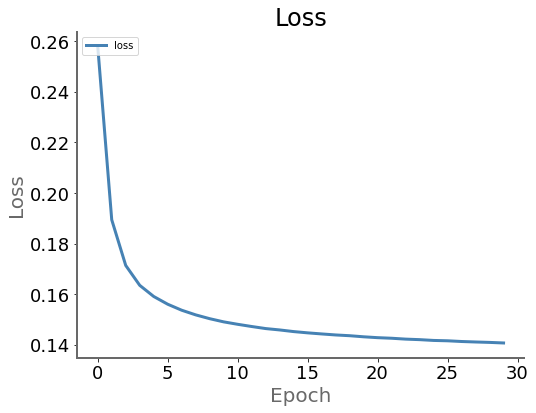

In [13]:
pwk.plot_history(history,  plot={"Loss":['loss']}, save_as='03-history')

## Step 7 - Learning progression

<br>**Real images :**

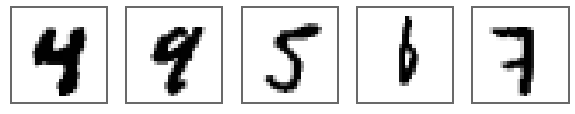

<br>**Noisy images :**

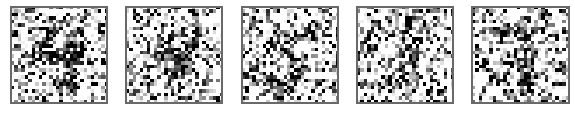

<br>**Learning...**

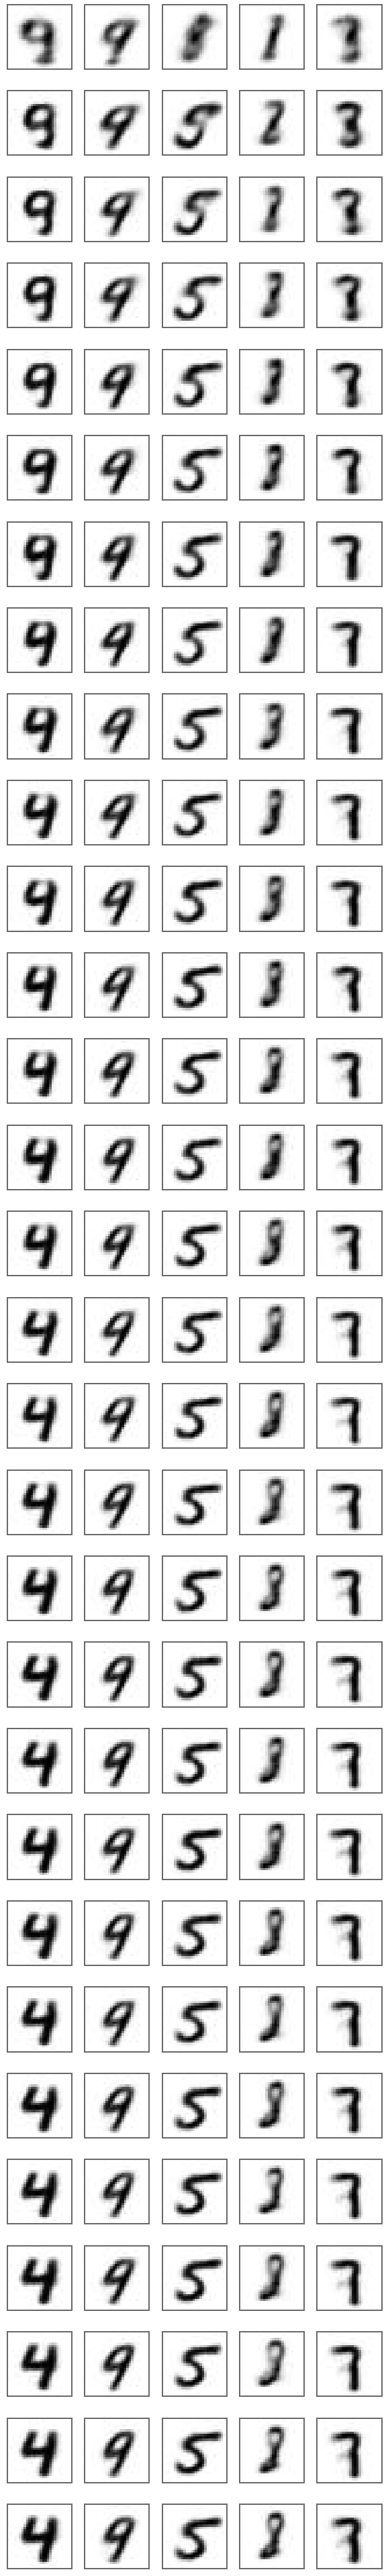

<br>**Noisy images :**

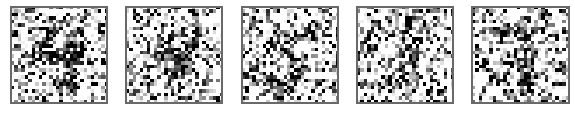

<br>**Real images :**

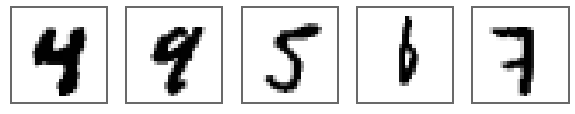

In [14]:
imgs=[]
labels=[]
for epoch in range(epochs):
    for i in range(5):
        filename = './run/images/image-{epoch:03d}-{i:02d}.jpg'.format(epoch=epoch, i=i)
        img      = io.imread(filename)
        imgs.append(img)
        

pwk.subtitle('Real images :')
pwk.plot_images(y_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as='04-original-real')

pwk.subtitle('Noisy images :')
pwk.plot_images(x_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as='05-original-noisy')

pwk.subtitle('Learning...')
pwk.plot_images(imgs, None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as='06-learning')

pwk.subtitle('Noisy images :')
pwk.plot_images(x_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as=None)

pwk.subtitle('Real images :')
pwk.plot_images(y_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as=None)


In [15]:
pwk.end()

End time is : Wednesday 10 February 2021, 11:00:06
Duration is : 00:02:11 912ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>